In [1]:
%matplotlib inline


# Feature transformations with ensembles of trees


Transform your features into a higher dimensional, sparse space. Then
train a linear model on these features.

First fit an ensemble of trees (totally random trees, a random
forest, or gradient boosted trees) on the training set. Then each leaf
of each tree in the ensemble is assigned a fixed arbitrary feature
index in a new feature space. These leaf indices are then encoded in a
one-hot fashion.

Each sample goes through the decisions of each tree of the ensemble
and ends up in one leaf per tree. The sample is encoded by setting
feature values for these leaves to 1 and the other feature values to 0.

The resulting transformer has then learned a supervised, sparse,
high-dimensional categorical embedding of the data.



In [70]:
# Author: Tim Head <betatim@gmail.com>
#
# License: BSD 3 clause

import numpy as np
np.random.seed(10)
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

result_= pd.read_csv('../../dev/risk_data.csv')
print(len(result_))

columns = ['RBI_STORY_POINTS', 'USERSTORIES_COUNT', 'RBI_TEAM_ID', 'RBI_THEME_ID','DEFECTS_CLOSED', 'DEFECTS_OPENED', 'RBI_RANK']

def create_sklearn_compatible_x_y(df):
    X = df[columns]
    y = df.label.values
    return X, y

n_estimator = 10
# X, y = make_classification(n_samples=80000)
X, y = create_sklearn_compatible_x_y(result_)
X = X.fillna(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)
print(len(y_test), len(y_train_lr), len(y_train))
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder(categorical_features = [2,3])
rf_lm = LogisticRegression()

rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)


233
(117, 58, 58)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
lm = LogisticRegression()
enc = OneHotEncoder(categorical_features = [2,3])


lm.fit(X_train, y_train)
# enc.fit(lm.fit(X_train))
lm.fit(enc.transform(lm.transform(X_train_lr)), y_train_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [53]:
# prob
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

y_rf_lm = rf_lm.predict(rf_enc.transform(rf.apply(X_test)))
print(metrics.classification_report(y_test, y_rf_lm))
print(metrics.confusion_matrix(y_test, y_rf_lm))


             precision    recall  f1-score   support

          0       0.90      0.91      0.90        95
          1       0.57      0.55      0.56        22

avg / total       0.83      0.84      0.84       117

[[86  9]
 [10 12]]


In [63]:

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder(categorical_features = [2,3])
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

y_grd_lm = grd_lm.predict(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))
print(metrics.classification_report(y_test, y_grd_lm))
print(metrics.confusion_matrix(y_test, y_grd_lm))

             precision    recall  f1-score   support

          0       0.93      0.94      0.93        95
          1       0.71      0.68      0.70        22

avg / total       0.89      0.89      0.89       117

[[89  6]
 [ 7 15]]


In [64]:
# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

y_grd = grd.predict(X_test)
print(metrics.classification_report(y_test, y_grd))
print(metrics.confusion_matrix(y_test, y_grd))

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
y_rf = rf.predict(X_test)
print(metrics.classification_report(y_test, y_rf))
print(metrics.confusion_matrix(y_test, y_rf))

             precision    recall  f1-score   support

          0       0.92      0.94      0.93        95
          1       0.70      0.64      0.67        22

avg / total       0.88      0.88      0.88       117

[[89  6]
 [ 8 14]]
             precision    recall  f1-score   support

          0       0.90      0.94      0.92        95
          1       0.67      0.55      0.60        22

avg / total       0.86      0.86      0.86       117

[[89  6]
 [10 12]]


In [74]:
X_test.columns

Index([u'RBI_STORY_POINTS', u'USERSTORIES_COUNT', u'RBI_TEAM_ID',
       u'RBI_THEME_ID', u'DEFECTS_CLOSED', u'DEFECTS_OPENED', u'RBI_RANK'],
      dtype='object')

In [44]:
# Unsupervised transformation based on totally random trees
# rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
# 	random_state=0)

# rt_lm = LogisticRegression()
# pipeline = make_pipeline(rt, rt_lm)
# pipeline.fit(X_train, y_train)
# y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
# fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

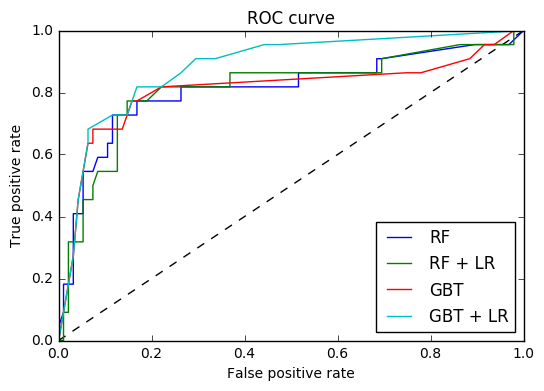

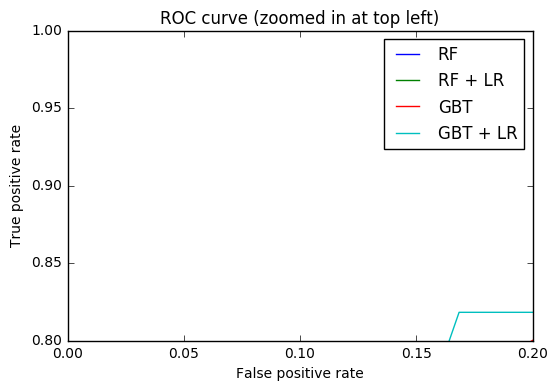

In [65]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()